> **Before the beginning I want to say that I hope you find this notebook helpful and some  UPVOTES would be very much appreciated. Thanks a lot.**

# Santander Customer Transaction Prediction
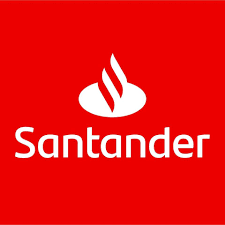

> # Introduction
> 
> In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
import logging
import datetime

import lightgbm as lgb

from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/Santander/"
else:
    PATH="../input/"
os.listdir(PATH)

['santander-customer-transaction-prediction']

In [3]:
# import Dataset to play with it
train= pd.read_csv("../input/santander-customer-transaction-prediction/train.csv")
test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
sample_submission = pd.read_csv('../input/santander-customer-transaction-prediction/sample_submission.csv')
sample_submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


# Data exploration

In [4]:
train.shape, test.shape, sample_submission.shape

((200000, 202), (200000, 201), (200000, 2))

In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


> **Reducing memory size about %50**
> Because we make a lot of calculations in this kernel, we'd better reduce the size of the data.

In [7]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [8]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 308.2276611328125  MB
******************************
Column:  target
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  fl

In [9]:
test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 306.7017822265625  MB
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_7
dtype before:  float64
dtype after: 

In [10]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [11]:
missing_data(train)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,uint8,float32,float32,float32,float32,float32,float32,float32,float32,...,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32


In [12]:
missing_data(test)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,...,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32


> **Numerical values Describe**
> *  There are no missing data in train and test datasets. Let's check the numerical values in train and test dataset.

In [13]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
target,200000.0,0.100490,0.300653,0.000000,0.000000,0.00000,0.000000,1.000000
var_0,200000.0,10.679973,3.039990,0.408400,8.453850,10.52475,12.758200,20.315001
var_1,200000.0,-1.627628,4.049967,-15.043400,-4.740025,-1.60805,1.358625,10.376800
var_2,200000.0,10.715126,2.640832,2.117100,8.722475,10.58000,12.516700,19.353001
var_3,200000.0,6.796523,2.043276,-0.040200,5.254075,6.82500,8.324100,13.188300
...,...,...,...,...,...,...,...,...
var_195,200000.0,-0.142087,1.429341,-5.261000,-1.170700,-0.17270,0.829600,4.272900
var_196,200000.0,2.303355,5.454274,-14.209600,-1.946925,2.40890,6.556725,18.321501
var_197,200000.0,8.908224,0.921603,5.960600,8.252800,8.88820,9.593300,12.000400
var_198,200000.0,15.870864,3.010892,6.299300,13.829700,15.93405,18.064724,26.079100


In [14]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
var_0,200000.0,10.658732,3.036675,0.188700,8.442975,10.51380,12.739600,22.323400
var_1,200000.0,-1.624240,4.040431,-15.043400,-4.700125,-1.59050,1.343400,9.385100
var_2,200000.0,10.707497,2.633820,2.355200,8.735600,10.56070,12.495025,18.714100
var_3,200000.0,6.788238,2.052685,-0.022400,5.230500,6.82235,8.327600,13.142000
var_4,200000.0,11.076387,1.616426,5.484400,9.891075,11.09975,12.253400,16.037100
...,...,...,...,...,...,...,...,...
var_195,200000.0,-0.133656,1.429652,-4.911900,-1.160700,-0.16200,0.837900,4.545400
var_196,200000.0,2.290916,5.446252,-13.944200,-1.948600,2.40360,6.519800,15.920700
var_197,200000.0,8.912555,0.920886,6.169600,8.260075,8.89280,9.595900,12.275800
var_198,200000.0,15.869393,3.008664,6.584000,13.847275,15.94340,18.045200,26.538401


# Data Visualization

<AxesSubplot:xlabel='target', ylabel='count'>

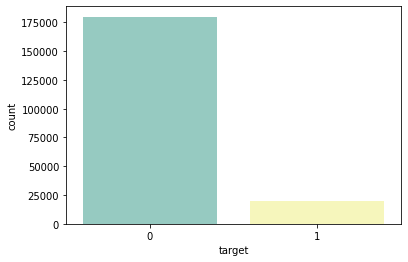

In [15]:
sns.countplot(train['target'], palette='Set3')

In [16]:
print("There are {}% target values with 1 on the train data".format(100 * train["target"].value_counts()[1]/train.shape[0]))

There are 10.049% target values with 1 on the train data


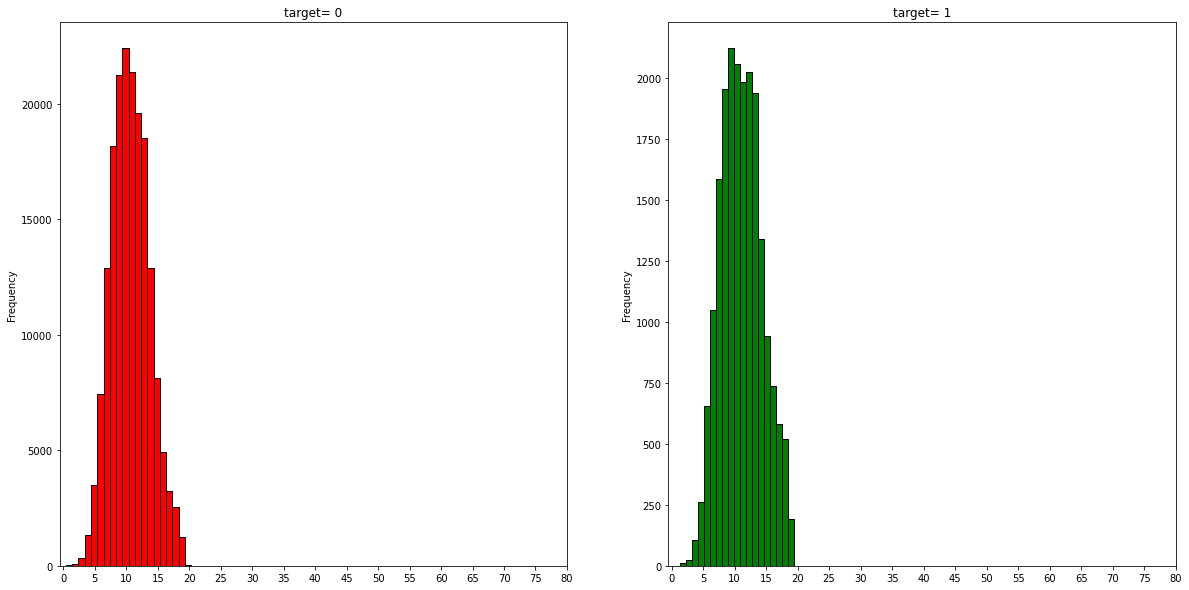

In [17]:
f,ax=plt.subplots(1,2,figsize=(20,10))
train[train['target']==0].var_0.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('target= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train[train['target']==1].var_0.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('target= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()


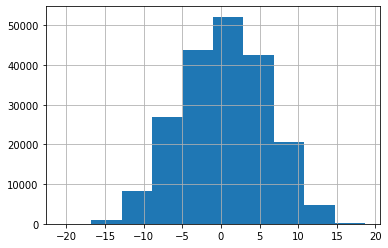

In [18]:
train["var_10"].hist();

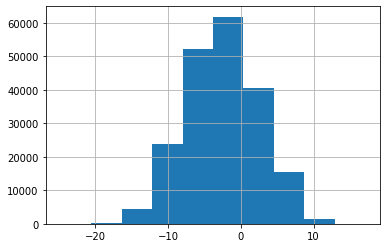

In [19]:
train["var_52"].hist();

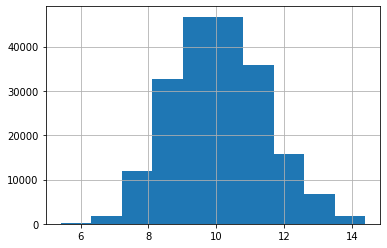

In [20]:
train["var_181"].hist();

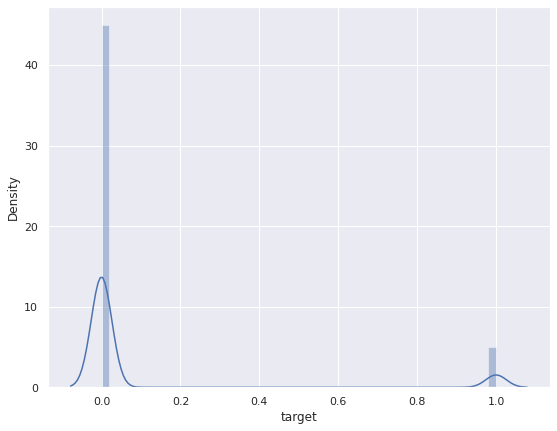

In [21]:
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train['target']);

> **The target in dataset is imbalance**

<AxesSubplot:xlabel='target', ylabel='var_10'>

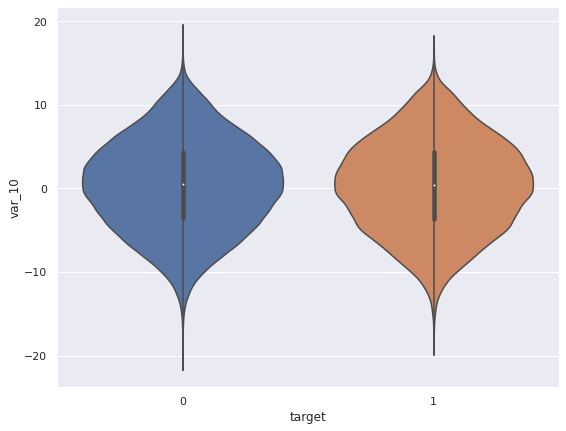

In [22]:
sns.violinplot(data=train,x="target", y="var_10")

<AxesSubplot:xlabel='target', ylabel='var_110'>

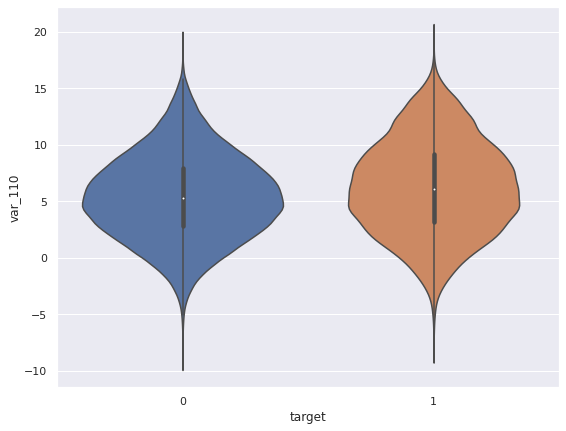

In [23]:
sns.violinplot(data=train,x="target", y="var_110")

<AxesSubplot:xlabel='target', ylabel='var_81'>

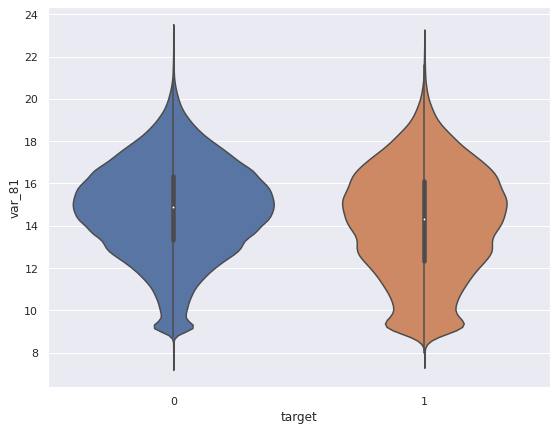

In [24]:
sns.violinplot(data=train,x="target", y="var_81")

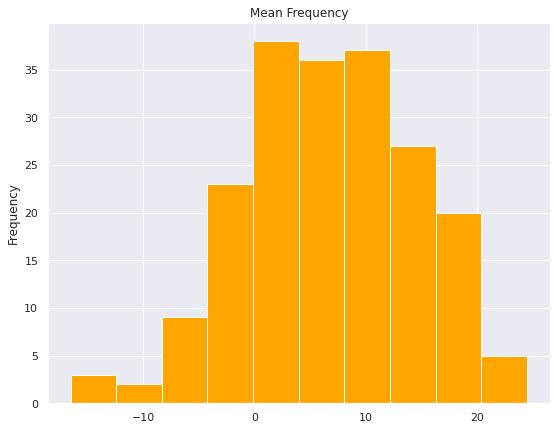

In [25]:
train[train.columns[2:]].mean().plot(kind='hist', color='#ffa600');plt.title('Mean Frequency');

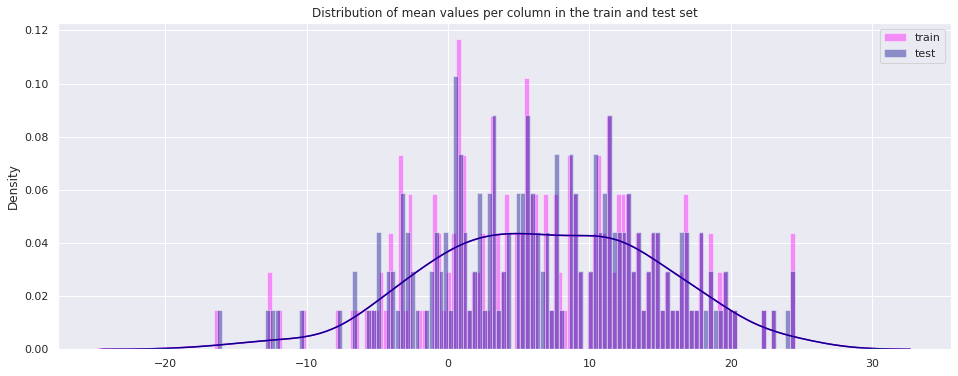

In [26]:
features = train.columns.values[2:202]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

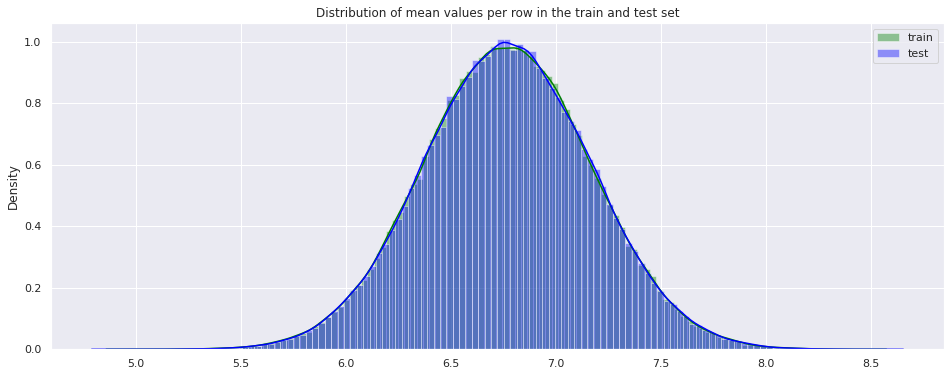

In [27]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

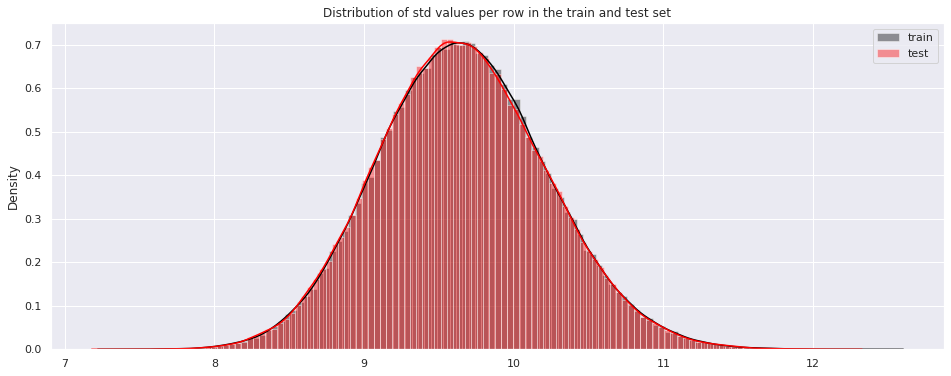

In [28]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

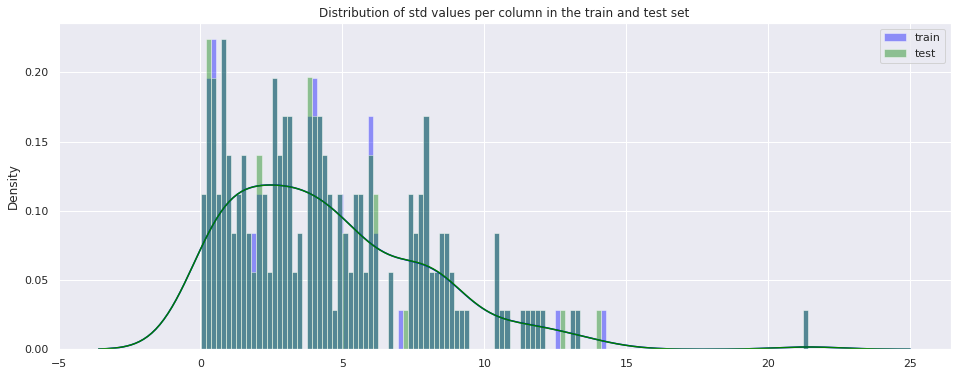

In [29]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

# Binary Classification

In [30]:
train['target'].unique()

array([0, 1], dtype=uint8)

In [31]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

> A large part of the data is unbalanced, but how can we solve it?

In [32]:
def check_balance(df,target):
    check=[]
    # written by MJ Bahmani for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('for target  {} ='.format(i))
        print(df[target].value_counts()[i]/df.shape[0]*100,'%')

In [33]:
check_balance(train,'target')

size of data is: 200000
for target  0 =
89.95100000000001 %
for target  1 =
10.049 %


In [34]:
#skewness and kurtosis
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


# Features correlation

In [35]:
%%time
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

CPU times: user 20.9 s, sys: 181 ms, total: 21.1 s
Wall time: 21.1 s


,level_0,level_1,0
0,var_75,var_191,2.675365e-08
1,var_191,var_75,2.675365e-08
2,var_173,var_6,5.886845e-08
3,var_6,var_173,5.886845e-08
4,var_126,var_109,1.326374e-07
5,var_109,var_126,1.326374e-07
6,var_144,var_27,1.769831e-07
7,var_27,var_144,1.769831e-07
8,var_177,var_100,3.114128e-07
9,var_100,var_177,3.114128e-07


In [36]:
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


# Duplicate values

In [37]:
%%time
features = train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 4.3 s, sys: 0 ns, total: 4.3 s
Wall time: 4.31 s


In [38]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head())
#TRAIN SET

,68,108,126,12,91
Feature,var_68,var_108,var_126,var_12,var_91
Max duplicates,1084,313,305,203,66
Value,5.0214,14.1999,11.5356,13.5545,6.9785


In [39]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head())
#TEST SET

,68,126,108,12,91
Feature,var_68,var_126,var_108,var_12,var_91
Max duplicates,1104,307,302,188,86
Value,5.0197,11.5357,14.1999,13.5546,6.9939


# Feature engineering

In [40]:
%%time
idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 5.11 s, sys: 2.42 s, total: 7.53 s
Wall time: 7.53 s


In [41]:
train[train.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.318481,-21.449400,43.112701,7.281592,9.331542,0.101580,1.331023,6.77040
1,1415.364014,-47.379700,40.563202,7.076820,10.336129,-0.351734,4.110215,7.22315
2,1240.896606,-22.403799,33.882000,6.204483,8.753386,-0.056957,0.546438,5.89940
3,1288.231567,-35.165901,38.101501,6.441158,9.594062,-0.480116,2.630499,6.70260
4,1354.230957,-65.486298,41.103699,6.771155,11.287124,-1.463426,9.787398,6.94735


In [42]:
test[test.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.640259,-31.989100,42.024799,7.083201,9.910631,-0.088518,1.871262,7.31440
1,1249.685791,-41.192402,35.602001,6.248429,9.541267,-0.559785,3.391068,6.43960
2,1430.260010,-34.348801,39.365398,7.151300,9.967464,-0.135084,2.326901,7.26355
3,1411.444946,-21.479700,40.338299,7.057225,8.257205,-0.167741,2.253054,6.89675
4,1423.736450,-24.825399,45.550999,7.118682,10.043544,0.293484,2.044943,6.83375


In [43]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

> Let's check the distribution of these new, engineered features.
> 
> We plot first the distribution of new features, grouped by value of corresponding target values.

<Figure size 648x504 with 0 Axes>

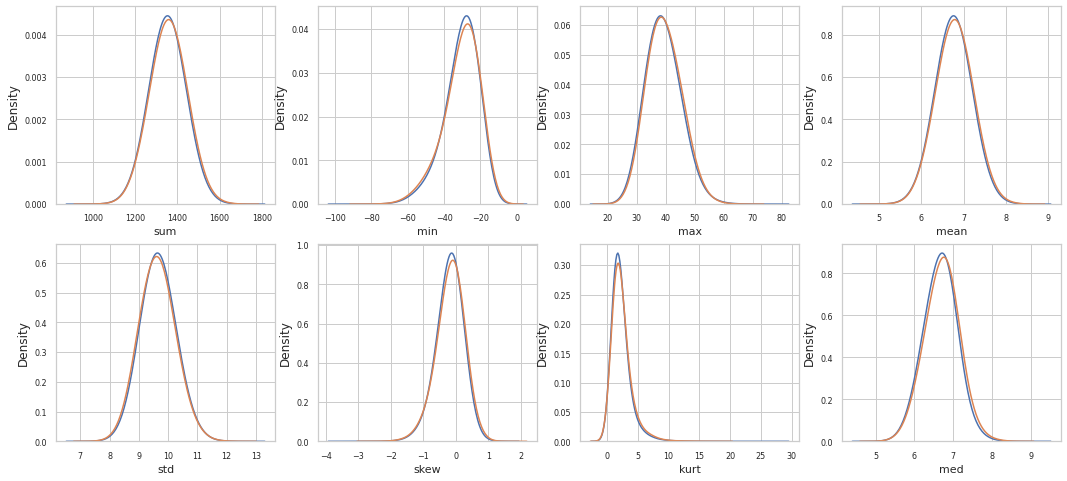

In [44]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

<Figure size 648x504 with 0 Axes>

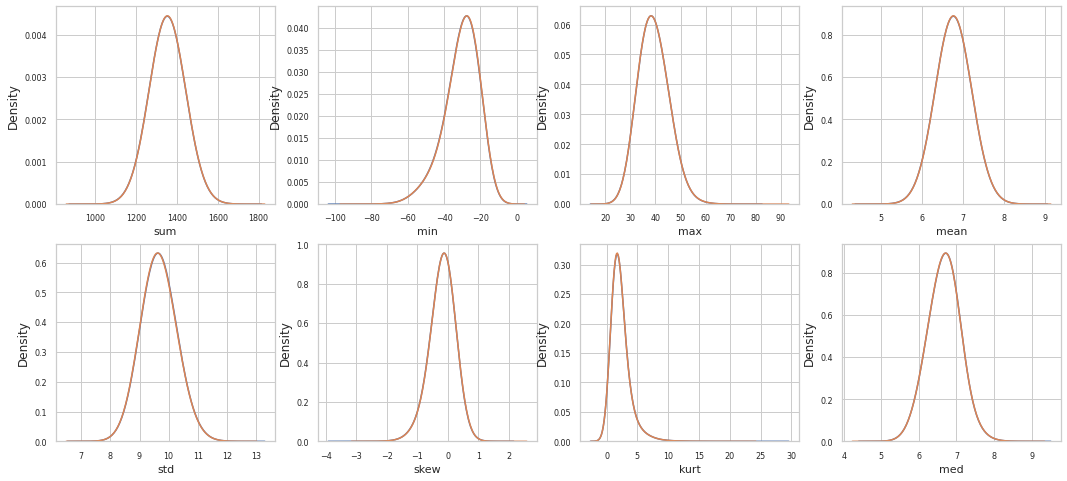

In [45]:
features = train.columns.values[202:]
plot_new_feature_distribution(train, test, 'train', 'test', features)

In [46]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
for feature in features:
    train['r2_'+feature] = np.round(train[feature], 2)
    test['r2_'+feature] = np.round(test[feature], 2)
    train['r1_'+feature] = np.round(train[feature], 1)
    test['r1_'+feature] = np.round(test[feature], 1)

In [47]:
print('Train and test columns: {} {}'.format(len(train.columns), len(test.columns)))

Train and test columns: 626 625


# Modelling

In [48]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

> **Hyperparameters for the model.**

In [49]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [50]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.907524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141423
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 623
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.885109	valid_1's auc: 0.864185
[2000]	training's auc: 0.909647	valid_1's auc: 0.884246
[3000]	training's auc: 0.921421	valid_1's auc: 0.892347
[4000]	training's auc: 0.928753	valid_1's auc: 0.896029
[5000]	training's auc: 0.93438	valid_1's auc: 0.897912
[6000]	training's auc: 0.939243	valid_1's auc: 0.89889
[7000]	training's auc: 0.943663	valid_1's auc: 0.899566
[8000]	training's auc: 0.947877	valid_1's auc: 0.899802
[9000]	training's auc: 0.951933	valid_1's auc: 0.900081
[10000]	training's auc: 0.955803	valid_1's auc: 0.900271
[11

# Submission

In [51]:
sub_enes = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_enes["target"] = predictions
sub_enes.to_csv("submission.csv", index=False)

# **References & credits **

1. https://www.kaggle.com/gpreda/elo-world-high-score-without-blending
2. https://www.kaggle.com/chocozzz/santander-lightgbm-baseline-lb-0-897
3. https://www.kaggle.com/brandenkmurray/nothing-works
4. https://www.kaggle.com/dansbecker/permutation-importance
5. https://www.kaggle.com/dansbecker/partial-plots
6. https://www.kaggle.com/miklgr500/catboost-with-gridsearch-cv
7. https://www.kaggle.com/dromosys/sctp-working-lgb
8. https://www.kaggle.com/gpreda/santander-eda-and-prediction
9. https://www.kaggle.com/dansbecker/permutation-importance
10. https://www.kaggle.com/dansbecker/partial-plots
11. https://www.kaggle.com/dansbecker/shap-values
12. https://docs.microsoft.com/en-us/azure/machine-learning/studio/algorithm-choice
13. https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
14. https://www.kaggle.com/brandenkmurray/nothing-works
15. https://www.kaggle.com/gpreda/santander-eda-and-prediction
16. https://www.kaggle.com/mjbahmani/santander-ml-explainability#--Santander-ML-Explainability--